# Sales analysis

In this notebook we analyze the **2019 sales data**: first we consolidate the monthly CSV files into a single dataset, then we apply **data cleaning**, create **new features** (month, city, sales), and finally perform **exploratory data analysis and visualizations** to answer business questions such as: best month, best city, best time of day, and products that are often bought together.

## Imports

In this cell we import the base libraries:
- `os` to work with files and folders (list CSV files in `Sales_Data`).
- `pandas` to load, clean, and analyze the tabular sales data.

In [1]:
import os
import pandas as pd

## Consolidate data for the full year

In this section we read all monthly CSV files from the `Sales_Data` folder and **merge them into a single DataFrame** (`data_anual`).

**Strategy:** *data consolidation* using a loop over the files and `pd.concat`, then we save the result to `consolidado_2019.csv` so it can be reused.

In [3]:
path = 'Sales_Data'
archivos = [file for file in os.listdir(path) if not file.startswith('.')]
print(archivos)
data_anual = pd.DataFrame()

for archivo in archivos:
    actual = pd.read_csv(path + '/' + archivo)
    data_anual = pd.concat([data_anual, actual])

data_anual.to_csv('consolidado_2019.csv', index=False)

['Sales_April_2019.csv', 'Sales_August_2019.csv', 'Sales_December_2019.csv', 'Sales_February_2019.csv', 'Sales_January_2019.csv', 'Sales_July_2019.csv', 'Sales_June_2019.csv', 'Sales_March_2019.csv', 'Sales_May_2019.csv', 'Sales_November_2019.csv', 'Sales_October_2019.csv', 'Sales_September_2019.csv']


In [4]:
data_anual.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [5]:
data_anual.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


## Data cleaning

Here we identify and remove **problematic rows** from the dataset:
- Completely empty rows (all columns are `NaN`).
- Rows where a **repeated header** from the original CSVs slipped into the data (detected because `Order Date` starts with `'Or'`).

**Strategy:** *data cleaning* using `dropna(how='all')` and logical string filters.

In [6]:
# drop empty rows
nan_df = data_anual[data_anual.isna().any(axis=1)]

data_anual = data_anual.dropna(how='all')

In [7]:
nan_df2 = data_anual[data_anual.isna().any(axis=1)]
nan_df2

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [8]:
data_anual = data_anual[data_anual['Order Date'].str[0:2] != 'Or']

### Convert numeric data

The columns `Quantity Ordered` and `Price Each` come as **text** from the CSV. Here we convert them to numeric types with `pd.to_numeric` so that we can:
- Compute total sales.
- Group and sum by month, city, etc.

**Strategy:** *type conversion* to ensure numeric columns are not left as strings.

In [9]:
data_anual['Quantity Ordered'] = pd.to_numeric(data_anual['Quantity Ordered'])
data_anual['Price Each'] = pd.to_numeric(data_anual['Price Each'])

In [10]:
type(data_anual['Price Each'][0].values[0])

numpy.float64

### Add month column

From the `Order Date` string (format `'MM/DD/YY HH:MM'`), we extract the **first two characters** to get the month (`1` to `12`) and convert it to a number with `pd.to_numeric`.

**Strategy:** *feature engineering* by creating a `Month` column that lets us group and compare sales by month.

In [11]:
data_anual['Month'] = pd.to_numeric(data_anual['Order Date'].str[:2])
data_anual.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4


In [12]:
def get_ciudad(direccion):
    return direccion.split(',')[1].strip(' ')
def get_estado(direccion):
    return direccion.split(',')[2].split(' ')[1]

In [13]:
get_estado('669 2nd St, New York City, NY 10001')

'NY'

In [14]:
data_anual['City'] = data_anual['Purchase Address'].apply(get_ciudad)
data_anual.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles


## Exploratory data analysis

With the dataset cleaned and new columns (`Month`, `City`, `Sales`) created, we can now answer business questions using **grouping**, **aggregation**, and **visualizations** (bar plots and line charts).

### Which month had the highest sales?

To answer this question:
1. We create a `Sales` column = `Quantity Ordered` × `Price Each` (revenue per row).
2. We group by `Month` and sum the `Sales` column to get total revenue per month.
3. We plot the result to visually see which month has the highest bar.3. Graficamos las ventas mensuales para ver visualmente qué mes tiene la barra más alta.

**Estrategias:**
- *Ingeniería de características:* columna `Sales`.
- *Agrupación y agregación:* `groupby('Month').sum()`.
- *Visualización:* gráfico de barras para comparar ingresos por mes.

In [15]:
data_anual['Sales'] = data_anual['Quantity Ordered'].astype('int') * data_anual['Price Each'].astype('float')
data_anual.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas,23.90
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston,99.99
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,600.00
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,11.99
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles,11.99


In [16]:
data_anual.groupby(['Month']).sum()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Sales
Month,,,,,,,,
1,2971502978172978172979692983442990492991253003...,Lightning Charging CableiPhoneLightning Chargi...,10903,1811768.38,01/01/20 00:3801/01/20 00:2201/01/20 00:2201/0...,"427 Wilson St, Dallas, TX 75001519 13th St, Ne...",DallasNew York CityNew York CitySan FranciscoN...,1822256.73
2,1505021505031505041505051505061505071505081505...,iPhoneAA Batteries (4-pack)27in 4K Gaming Moni...,13449,2188884.72,02/18/19 01:3502/13/19 07:2402/18/19 09:4602/0...,"866 Spruce St, Portland, ME 0410118 13th St, S...",PortlandSan FranciscoNew York CityAtlantaSeatt...,2202022.42
3,1505331505411508121517491520361532841535441538...,AAA Batteries (4-pack)AAA Batteries (4-pack)Wi...,17005,2791207.83,03/01/19 03:0603/01/19 01:0303/01/19 02:1803/0...,"270 Dogwood St, San Francisco, CA 94016683 Ada...",San FranciscoPortlandSan FranciscoSan Francisc...,2807100.38
4,1765581765591765601765601765611765621765631765...,USB-C Charging CableBose SoundSport Headphones...,20558,3367671.02,04/19/19 08:4604/07/19 22:3004/12/19 14:3804/1...,"917 1st St, Dallas, TX 75001682 Chestnut St, B...",DallasBostonLos AngelesLos AngelesLos AngelesS...,3390670.24
5,1769781775511777781777781790761790761791341800...,Apple Airpods Headphones27in FHD MonitoriPhone...,18667,3135125.13,05/01/19 03:2905/01/19 00:1305/01/19 00:4805/0...,"589 Lake St, Portland, OR 97035615 Lincoln St,...",PortlandSan FranciscoBostonBostonSan Francisco...,3152606.75
6,2099212099222099232099242099252099262099272099...,USB-C Charging CableMacbook Pro LaptopThinkPad...,15253,2562025.61,06/23/19 19:3406/30/19 10:0506/24/19 20:1806/0...,"950 Walnut St, Portland, ME 0410180 4th St, Sa...",PortlandSan FranciscoLos AngelesSeattleSan Fra...,2577802.26
7,2229102229112229122229132229142229152229162229...,Apple Airpods HeadphonesFlatscreen TVAA Batter...,16072,2632539.56,07/26/19 16:5107/05/19 08:5507/29/19 12:4107/2...,"389 South St, Atlanta, GA 30301590 4th St, Sea...",AtlantaSeattleAtlantaAtlantaSeattleSan Francis...,2647775.76
8,2366702366712366722366732366742366752366762366...,Wired HeadphonesBose SoundSport HeadphonesiPho...,13448,2230345.42,08/31/19 22:2108/15/19 15:1108/06/19 14:4008/2...,"359 Spruce St, Seattle, WA 98101492 Ridge St, ...",SeattleDallasPortlandLos AngelesNew York CityS...,2244467.88
9,2388342392852406362410542423432428652436672449...,Apple Airpods Headphones34in Ultrawide Monitor...,13109,2084992.09,09/01/19 04:1309/01/19 01:0909/01/19 02:0709/0...,"761 Forest St, San Francisco, CA 94016373 1st ...",San FranciscoSan FranciscoSeattleSan Francisco...,2097560.13


Text(0.5, 0, 'Month')

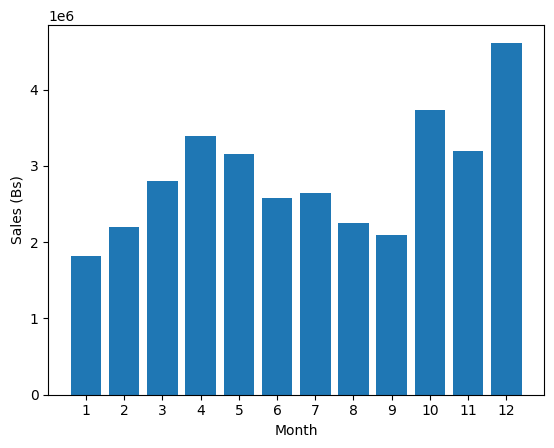

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
months = range(1, 13)

plt.bar(months, data_anual.groupby(['Month']).sum()['Sales'])
plt.xticks(months)
plt.ylabel('Sales (Bs)')
plt.xlabel('Month')


### Which city has the highest sales?

Here we group the data by `City` and sum the `Sales` column to compare total revenue per city. We then plot a bar chart (with rotated labels) to quickly see which city generates the most sales.

In [18]:
data_anual.groupby(['City']).sum()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales
City,,,,,,,,
Atlanta,1765641765711765821765891766231766271766341766...,USB-C Charging CableLightning Charging CableBo...,16602,2779908.20,04/12/19 10:5804/19/19 14:2904/27/19 12:2004/0...,"790 Ridge St, Atlanta, GA 30301253 Johnson St,...",104794,2795498.58
Austin,1765911766091766741766771766861767011767051767...,Apple Airpods HeadphonesApple Airpods Headphon...,11153,1809873.61,04/21/19 07:2104/11/19 16:5904/20/19 20:5304/0...,"600 Maple St, Austin, TX 73301267 11th St, Aus...",69829,1819581.75
Boston,1765591765661765781765811765851765851766001766...,Bose SoundSport HeadphonesWired HeadphonesAppl...,22528,3637409.77,04/07/19 22:3004/08/19 14:0504/09/19 23:3504/0...,"682 Chestnut St, Boston, MA 0221583 7th St, Bo...",141112,3661642.01
Dallas,1765581765691765701765771765961766021766101766...,USB-C Charging Cable27in 4K Gaming MonitorAA B...,16730,2752627.82,04/19/19 08:4604/16/19 19:2304/22/19 15:0904/0...,"917 1st St, Dallas, TX 75001657 Hill St, Dalla...",104620,2767975.40
Los Angeles,1765601765601765611765671765741765741765761765...,Google PhoneWired HeadphonesWired HeadphonesGo...,33289,5421435.23,04/12/19 14:3804/12/19 14:3804/30/19 09:2704/1...,"669 Spruce St, Los Angeles, CA 90001669 Spruce...",208325,5452570.80
New York City,1765721765751765791765901765991766131766371766...,Apple Airpods HeadphonesAAA Batteries (4-pack)...,27932,4635370.83,04/04/19 20:3004/27/19 00:3004/11/19 10:2304/1...,"149 Dogwood St, New York City, NY 10001433 Hil...",175741,4664317.43
Portland,1765831765931766171766421766461766481766621767...,AAA Batteries (4-pack)Lightning Charging Cable...,14053,2307747.47,04/20/19 12:0004/15/19 13:4504/25/19 08:0304/1...,"146 Jackson St, Portland, OR 97035906 7th St, ...",87765,2320490.61
San Francisco,1765621765651765731765841765861765861765941765...,USB-C Charging CableMacbook Pro LaptopUSB-C Ch...,50239,8211461.74,04/29/19 13:0304/24/19 10:3804/27/19 18:4104/2...,"381 Wilson St, San Francisco, CA 94016915 Will...",315520,8262203.91
Seattle,1765631765681765881766121766241766541766631766...,Bose SoundSport HeadphonesLightning Charging C...,16553,2733296.01,04/02/19 07:4604/15/19 12:1804/02/19 04:0004/0...,"668 Center St, Seattle, WA 98101438 Elm St, Se...",104941,2747755.48


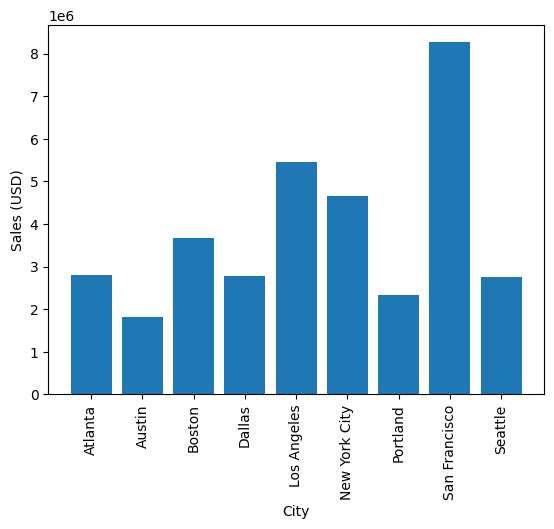

In [22]:
sales_by_city = data_anual.groupby('City')['Sales'].sum()

cities = sales_by_city.index           # e.g. Index(['Dallas', 'Seattle', ...])
values = sales_by_city.values          # corresponding totals

plt.bar(cities, values)
plt.xticks(cities, rotation='vertical')
plt.ylabel('Sales (USD)')
plt.xlabel('City')
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

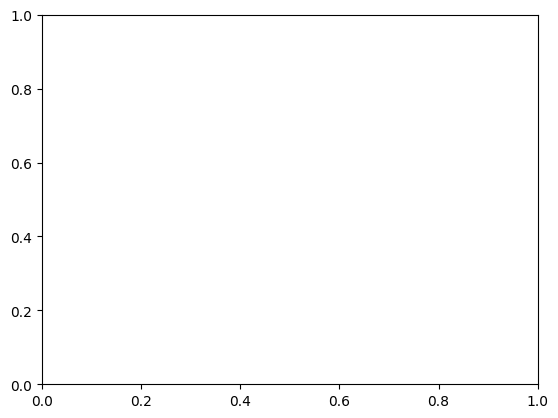

In [20]:
ciudades = [ciudad for ciudad, df in data_anual.groupby(['City'])]
plt.bar(ciudades, data_anual.groupby(['City']).sum()['Sales'])
plt.xticks(ciudades, rotation='vertical')
plt.ylabel('Sales (USD)')
plt.xlabel('City')

### At what time should we show ads to improve our sales?

Here we create an `Hour` column from the `Order Date` timestamp, group by hour, and count the number of orders. Plotting this as a line chart reveals the hours of the day with the highest order volume, which are good candidates for scheduling advertising.

In [23]:
data_anual['Hour'] = pd.to_datetime(data_anual['Order Date']).dt.hour
data_anual.head()

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_54496\546276567.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_anual['Hour'] = pd.to_datetime(data_anual['Order Date']).dt.hour


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas,23.90,8
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston,99.99,22
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,600.00,14
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,11.99,14
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles,11.99,9


In [24]:
data_anual['Count'] = 1
data_anual.head(15)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour,Count
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas,23.90,8,1
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston,99.99,22,1
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,600.00,14,1
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles,11.99,14,1
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles,11.99,9,1
6,176562,USB-C Charging Cable,1,11.95,04/29/19 13:03,"381 Wilson St, San Francisco, CA 94016",4,San Francisco,11.95,13,1
7,176563,Bose SoundSport Headphones,1,99.99,04/02/19 07:46,"668 Center St, Seattle, WA 98101",4,Seattle,99.99,7,1
8,176564,USB-C Charging Cable,1,11.95,04/12/19 10:58,"790 Ridge St, Atlanta, GA 30301",4,Atlanta,11.95,10,1
9,176565,Macbook Pro Laptop,1,1700.00,04/24/19 10:38,"915 Willow St, San Francisco, CA 94016",4,San Francisco,1700.00,10,1
10,176566,Wired Headphones,1,11.99,04/08/19 14:05,"83 7th St, Boston, MA 02215",4,Boston,11.99,14,1


In [25]:
data_anual.groupby(['Hour']).count()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Count
Hour,,,,,,,,,,
0,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910
1,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350
2,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243
3,831,831,831,831,831,831,831,831,831,831
4,854,854,854,854,854,854,854,854,854,854
5,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321
6,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482
7,4011,4011,4011,4011,4011,4011,4011,4011,4011,4011
8,6256,6256,6256,6256,6256,6256,6256,6256,6256,6256


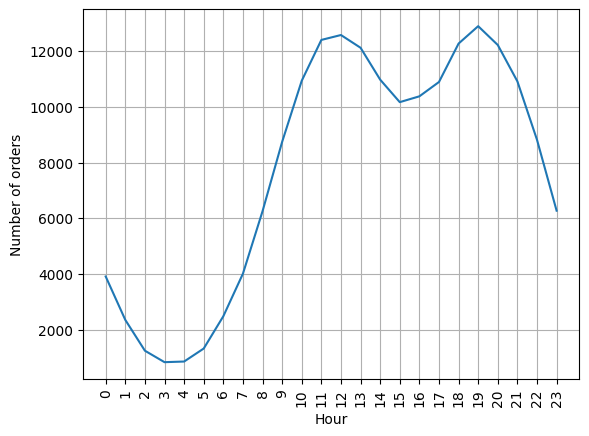

In [27]:
# Count number of orders per hour
hour_counts = data_anual.groupby('Hour')['Order ID'].count()

hours = hour_counts.index        # x values: 0–23
counts = hour_counts.values      # y values: number of orders

plt.plot(hours, counts)
plt.xticks(hours, rotation='vertical')
plt.ylabel('Number of orders')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

ValueError: 'locs' must be 1D with shape (N,), but your input has shape (24, 1)

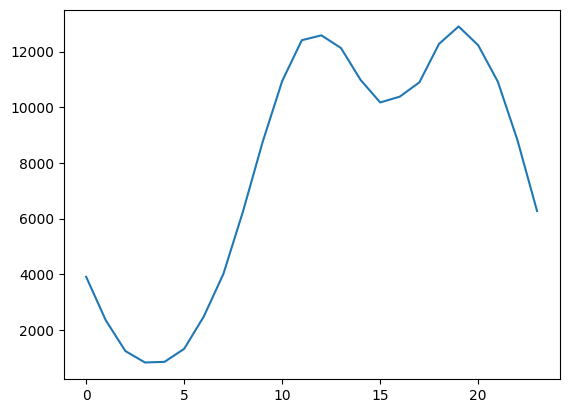

In [26]:
horas = [hora for hora, df in data_anual.groupby(['Hour'])]
plt.plot(horas, data_anual.groupby(['Hour']).count()['Count'])
plt.xticks(horas, rotation='vertical')
plt.ylabel('Numero de ordenes')
plt.xlabel('Hora')

### cuales son los productos que se venden mas a menudo juntos?

In [ ]:
df = data_anual[data_anual['Order ID'].duplicated(keep=False)]
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ', '.join(x))
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour,Count,Grouped
15,194110,Google Phone,1,600.00,05/31/19 18:07,"498 14th St, Los Angeles, CA 90001",5,Los Angeles,600.00,18,1,"Google Phone, Wired Headphones"
16,194110,Wired Headphones,1,11.99,05/31/19 18:07,"498 14th St, Los Angeles, CA 90001",5,Los Angeles,11.99,18,1,"Google Phone, Wired Headphones"
77,194170,Google Phone,1,600.00,05/30/19 12:30,"711 Maple St, San Francisco, CA 94016",5,San Francisco,600.00,12,1,"Google Phone, USB-C Charging Cable"
78,194170,USB-C Charging Cable,2,11.95,05/30/19 12:30,"711 Maple St, San Francisco, CA 94016",5,San Francisco,23.90,12,1,"Google Phone, USB-C Charging Cable"
82,194174,iPhone,1,700.00,05/04/19 23:08,"37 North St, Seattle, WA 98101",5,Seattle,700.00,23,1,"iPhone, Lightning Charging Cable, Wired Headph..."


In [ ]:
df2 = df[['Order ID', 'Grouped']].drop_duplicates()
df2.head()

,Order ID,Grouped
15,194110,"Google Phone, Wired Headphones"
77,194170,"Google Phone, USB-C Charging Cable"
82,194174,"iPhone, Lightning Charging Cable, Wired Headph..."
89,194179,"Flatscreen TV, AAA Batteries (4-pack)"
103,194192,"Wired Headphones, Bose SoundSport Headphones"


In [ ]:
from itertools import combinations
from collections import Counter

contador = Counter()

for fila in df2['Grouped']:
    lista_prod = fila.split(',')
    contador.update(Counter(combinations(lista_prod, 2)))

# menos comunes
contador.most_common()[:-50-1:-1]

[((' Bose SoundSport Headphones', ' 27in FHD Monitor'), 1),
 ((' Lightning Charging Cable', ' 34in Ultrawide Monitor'), 1),
 (('LG Dryer', ' Wired Headphones'), 1),
 (('LG Washing Machine', ' iPhone'), 1),
 (('Google Phone', ' 27in 4K Gaming Monitor'), 1),
 (('34in Ultrawide Monitor', ' LG Washing Machine'), 1),
 (('Google Phone', ' Flatscreen TV'), 1),
 ((' Bose SoundSport Headphones', ' 34in Ultrawide Monitor'), 1),
 ((' USB-C Charging Cable', ' 34in Ultrawide Monitor'), 1),
 (('ThinkPad Laptop', ' Vareebadd Phone'), 1),
 (('Macbook Pro Laptop', ' Flatscreen TV'), 1),
 (('LG Dryer', ' Vareebadd Phone'), 1),
 (('20in Monitor', ' iPhone'), 1),
 ((' USB-C Charging Cable', ' Vareebadd Phone'), 1),
 (('Google Phone', ' Vareebadd Phone'), 1),
 ((' Wired Headphones', ' 27in 4K Gaming Monitor'), 1),
 ((' Wired Headphones', ' Google Phone'), 1),
 ((' Apple Airpods Headphones', ' Google Phone'), 1),
 (('LG Washing Machine', ' Wired Headphones'), 1),
 (('LG Washing Machine', ' Google Phone'), 1